In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [5]:
path = 'QCM12.csv'
df = pd.read_csv(path)
df.head()

,0.799_0.201,0.799_0.201.1,0.700_0.300,0.700_0.300.1,0.600_0.400,0.600_0.400.1,0.501_0.499,0.501_0.499.1,0.400_0.600,0.400_0.600.1,1-Octanol,1-Propanol,2-Butanol,2-propanol,1-isobutanol
0,-9.40,-7.95,-21.44,-17.46,-34.39,-27.35,-48.61,-39.91,-63.62,-53.14,1,0,0,0,0
1,-13.18,-12.01,-26.46,-22.75,-41.48,-34.60,-56.74,-48.68,-73.45,-63.17,1,0,0,0,0
2,-18.61,-16.29,-32.84,-28.72,-49.32,-42.29,-65.87,-57.89,-84.45,-73.99,1,0,0,0,0
3,-21.88,-19.81,-38.18,-33.77,-56.27,-48.93,-74.09,-65.99,-92.61,-83.37,1,0,0,0,0
4,-24.84,-22.36,-42.61,-37.94,-60.47,-53.86,-80.67,-72.62,-101.14,-91.33,1,0,0,0,0


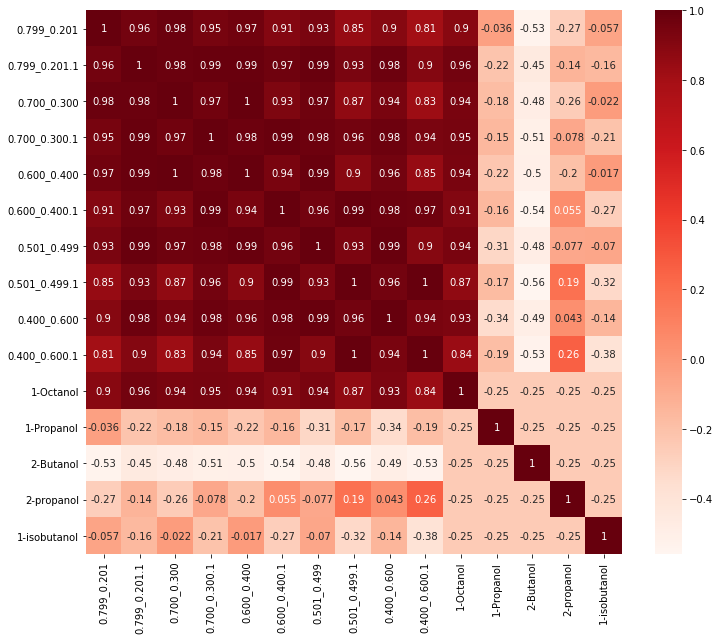

In [11]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [15]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["1-Octanol"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.5]
relevant_features

0.799_0.201      0.896336
0.799_0.201.1    0.963422
0.700_0.300      0.939950
0.700_0.300.1    0.948144
0.600_0.400      0.942126
0.600_0.400.1    0.914265
0.501_0.499      0.944646
0.501_0.499.1    0.867981
0.400_0.600      0.928261
0.400_0.600.1    0.841379
1-Octanol        1.000000
Name: 1-Octanol, dtype: float64

In [16]:
print(df[["0.799_0.201","0.700_0.300"]].corr())
print(df[["0.600_0.400.1","0.400_0.600.1"]].corr())

             0.799_0.201  0.700_0.300
0.799_0.201     1.000000     0.981817
0.700_0.300     0.981817     1.000000
               0.600_0.400.1  0.400_0.600.1
0.600_0.400.1       1.000000       0.974769
0.400_0.600.1       0.974769       1.000000


In [17]:

#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

AGE        9.582293e-01
INDUS      7.382881e-01
CHAS       1.925030e-03
TAX        1.111637e-03
CRIM       1.086810e-03
ZN         7.781097e-04
B          5.728592e-04
RAD        5.070529e-06
NOX        4.245644e-06
const      3.283438e-12
PTRATIO    1.308835e-12
DIS        6.013491e-13
RM         1.979441e-18
LSTAT      7.776912e-23
dtype: float64

In [18]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [19]:

model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


In [20]:

#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 10
Desempeño con 10 características: 0.663581


In [21]:

cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


In [22]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:10
Desempeño mediante la regularización Lasso: 0.702444


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

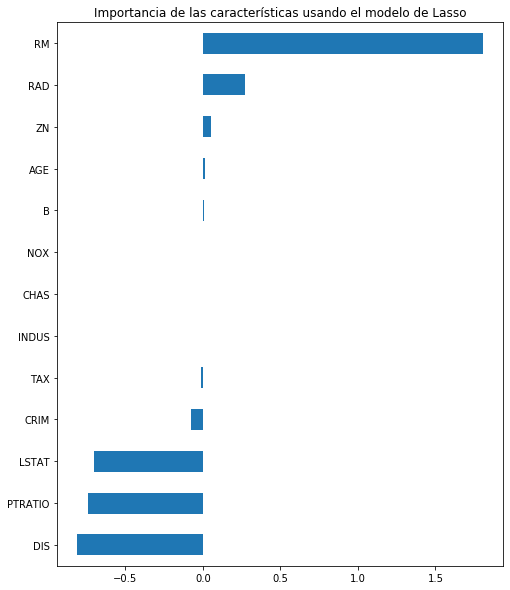

In [23]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")